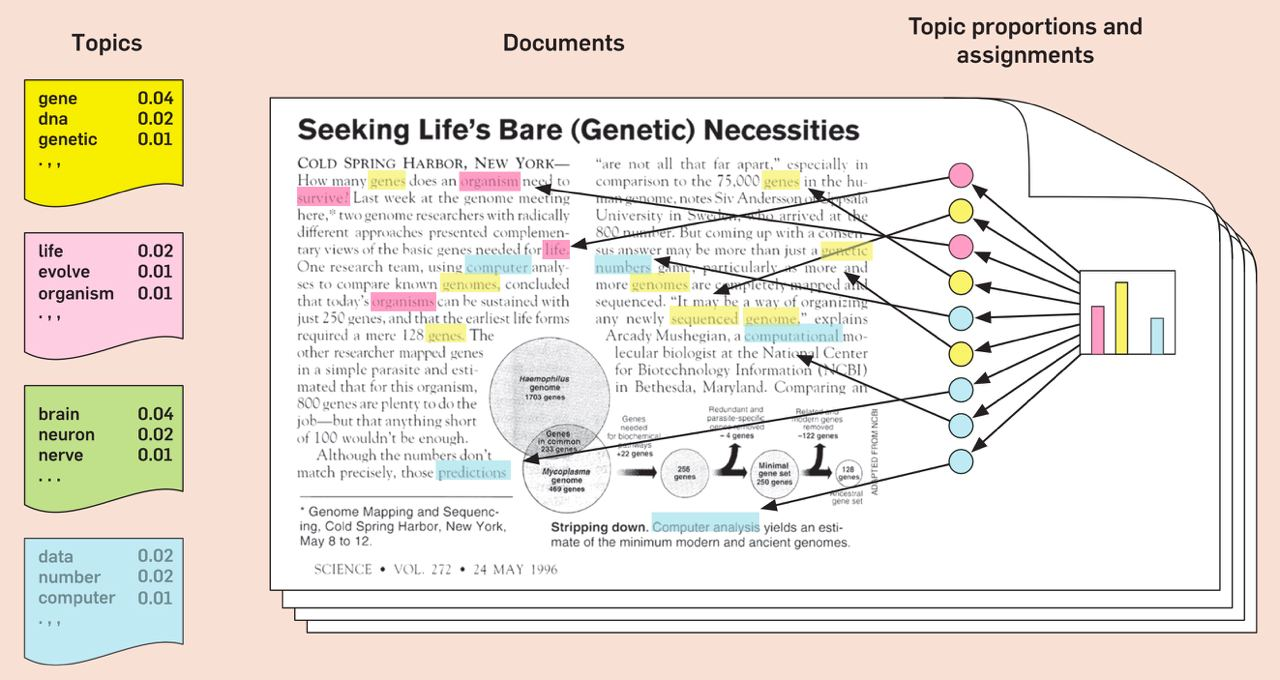

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PATH = '/content/drive/MyDrive/mkn/nlp/hw7/'

In [3]:
import pathlib
from typing import Tuple, List, Dict, Iterable
import numpy as np
from tqdm import tqdm

In [4]:
class Vocab:
    def __init__(self, path: pathlib.Path):
        self.idx2token, self.token2idx = self.extract_vocab(path)
    
    def extract_vocab(self, path: pathlib.Path) -> Tuple[List[str], Dict[str, int]]:
        idx2token = []
        token2idx = {}
        with open(path) as v_file:
            for word in v_file.readlines():
                word = word.strip()
                token2idx[word] = len(idx2token)
                idx2token.append(word)
        return idx2token, token2idx
    
    def __len__(self):
        return len(self.idx2token)

In [5]:

class Corpus:
    def __init__(self, path: pathlib.Path, vocab: Vocab, return_words: bool = False):
        self._data = self._extract_data(path)
        self.vocab = vocab
        self.return_words = return_words

        # Тензор N_docs X N_words где на местах слов вставлено, сколько раз это слово встречается в документе
        self.X = self._extract_coocurence_matrix()
    
    def _extract_data(self, path: pathlib.Path) -> List[List[int]]:
        data = []
        with open(path) as d_path:
            for doc in d_path.readlines():
                doc = [int(d.split(':')[0]) - 1 for d in doc.strip().split(",")]
                data.append(doc)
            return data
    
    def _extract_coocurence_matrix(self):
        X = np.zeros(shape=(self.n_docs, self.n_words))
        for doc_idx, dat in enumerate(self._data):
            for word_idx in dat:
                X[doc_idx, word_idx] += 1
        return X
    
    def __iter__(self):
        for doc in self._data:
            if self.return_words:
                yield [self._vocab.idx2token[w] for w in doc]
            else:
                yield doc
    
    @property
    def n_words(self):
        return len(self.vocab)
    
    @property
    def n_docs(self):
        return len(self._data)

In [6]:
k = Vocab(PATH + 'nyt-vocab.txt')

In [7]:
d = Corpus(PATH + "nyt-articles.txt", k)

### pLSA E-step + M-step + Likelihood + predict [3 + 3 + 1 балла]

In [10]:
from numpy import ndarray
from typing import Optional

class PLSA:
    def __init__(self, n_topics: int, max_iter: int = 100, eps: float = 1e-5):
        self._max_iter = max_iter
        self._eps = eps
        self._n_topics = n_topics
        
        # Оценка P(w|t)
        # topics X words
        
        self._phi: Optional[ndarray] = None
        
        # Оценка P(t|d)
        # docs X topics
        
        self._theta: Optional[ndarray] = None
    
    def fit(self, corpus: Corpus):
        self._phi, self._theta = self._initialize(corpus.n_words, corpus.n_docs)
        self.n_words, self.n_docs = corpus.n_words, corpus.n_docs
        old_likelihood = 1
        for it in tqdm(range(self._max_iter)):
            
            # Оценка P(t|d,w)
            # docs X words X topics
            Ptdw = self._e_step(self._phi, self._theta, corpus.X)
            print(f'estep {it}/{self._max_iter} done')
            self._phi, self._theta = self._m_step(Ptdw, corpus.X)
            print(f'mstep {it}/{self._max_iter} done')
            new_likelihood = self._likelihood(self._phi, self._theta, corpus.X)
            print(f'll')
            print(f'new_likelihood: {new_likelihood}')
            if np.abs(new_likelihood - old_likelihood) < self._eps:
                break
            old_likelihood = new_likelihood
    
    
    def _e_step(self, phi: ndarray, theta: ndarray, X: ndarray) -> ndarray:
        #p = np.einsum('tw, dt -> dwt', phi, theta).astype('float64')
        #print(f'phi(tw): {phi.shape}\ntheta(dt): {theta.shape}\np(dtw): {_p.shape}')

        #t_sum = p.sum(axis=(0, 1))
        #t_sum = np.divide(1, t_sum)
        #t_sum[t_sum == np.inf] = 0
        #p = np.einsum('dwt, t, dw -> dwt', p, t_sum, X)
        
        

        #topic_sums = np.zeros((self.n_words, self.n_docs))

        '''
        for t in tqdm(range(self._n_topics)):
            topic_counter = 0
            for d in range(self.n_docs):
                for w in range(self.n_words):
                    #topic_sums[w, d] += phi[t, w] * theta[d, t]
                    topic_counter += phi[t, w] * theta[d, t]
                    buf_wt[w, t] += phi[t, w] * theta[d, t] * X[d, w]
                    buf_dt[d, t] += phi[t, w] * theta[d, t] * X[d, w]

            buf_wt /= topic_counter
            buf_dt /= topic_counter
            nwt += buf_wt
            ndt += buf_dt
            buf_wt = np.zeros((self.n_words, self._n_topics))
            buf_dt = np.zeros((self.n_docs, self._n_topics))
        '''

        ptdw = np.zeros((self._n_topics, self.n_docs, self.n_words))


        topic_sums = theta @ phi


        for t in range(self._n_topics):
            ptdw[t] = np.outer(theta[:, t], phi[t, :]) / topic_sums

        return ptdw
    
    def _m_step(self, ptdw: ndarray, X: ndarray) -> Tuple[ndarray, ndarray]:
        ntdw = ptdw * X
        del ptdw
        ntw = ntdw.sum(axis=1)
        ntd = ntdw.sum(axis=2)
        
        #ndwt = np.einsum('dw, tdw -> dwt', X, ptdw)
        #nwt = pdwt.sum(axis=0)
        #ndt = pdwt.sum(axis=1)
        #nwt, ndt = pdwt
        nt = np.divide(1, ntw.sum(axis=1))
        nd = np.divide(1, ntd.sum(axis=0))

                
        phi = np.einsum('tw, t -> tw', ntw, nt)
        theta = np.einsum('td, d -> dt', ntd, nd)
        del ntw, ntd, nt, nd
        phi[phi != phi] = 1 / self.n_words
        theta[theta != theta] = 1 / self.n_docs

        
        return phi, theta
    
    def _likelihood(self, phi: ndarray, theta: ndarray, X: ndarray):
        PT = theta @ phi
        PT[PT == 0] = 1e-10
        loglikelihood = np.einsum('dw, dw ->', X, np.log(PT))
        return loglikelihood
    
    def _initialize(self, n_words: int, n_docs: int) -> Tuple[ndarray, ndarray]:
        phi = np.random.uniform(0, 1, size=(self._n_topics, n_words))
        theta = np.random.uniform(0, 1, size=(n_docs, self._n_topics))
        return (phi / np.sum(phi, axis=1, keepdims=1)), (theta / np.sum(theta, axis=1, keepdims=1))
    
    def predict(self, top_k: int) -> List[List[str]]:
        def print_top(topic, best_idx):
            print(f'topic {topic}:')
            tab = '    '
            for i in best_idx:
                print(tab + f'{self.idx2token[i]} {self._phi[topic, i]}')


        for topic, words in enumerate(self._phi):
            best_idx = np.argsort(words)[:top_k]
            print_top(topic, best_idx)

In [ ]:
plsa = PLSA(25, 300)
plsa.fit(d)

  0%|          | 0/300 [00:00<?, ?it/s]

estep 0/300 done
mstep 0/300 done


  0%|          | 1/300 [00:17<1:29:09, 17.89s/it]

ll
new_likelihood: -7341279.081605081


<ipython-input-10-9aea91e6382e>:78: RuntimeWarning: invalid value encountered in true_divide
  ptdw[t] = np.outer(theta[:, t], phi[t, :]) / topic_sums


estep 1/300 done
mstep 1/300 done


  1%|          | 2/300 [00:29<1:11:03, 14.31s/it]

ll
new_likelihood: -13322099.00945799
estep 2/300 done
mstep 2/300 done


  1%|          | 3/300 [00:40<1:02:46, 12.68s/it]

ll
new_likelihood: -7342537.4557956485
estep 3/300 done
mstep 3/300 done


  1%|▏         | 4/300 [00:51<59:13, 12.00s/it]  

ll
new_likelihood: -13322099.00945799
estep 4/300 done
mstep 4/300 done


  2%|▏         | 5/300 [01:02<56:33, 11.50s/it]

ll
new_likelihood: -7342537.4557956485
estep 5/300 done
mstep 5/300 done


  2%|▏         | 6/300 [01:12<54:48, 11.18s/it]

ll
new_likelihood: -13322099.00945799
estep 6/300 done
mstep 6/300 done


  2%|▏         | 7/300 [01:23<53:42, 11.00s/it]

ll
new_likelihood: -7342537.4557956485
estep 7/300 done
mstep 7/300 done


  3%|▎         | 8/300 [01:34<53:34, 11.01s/it]

ll
new_likelihood: -13322099.00945799
estep 8/300 done
mstep 8/300 done


  3%|▎         | 9/300 [01:44<52:45, 10.88s/it]

ll
new_likelihood: -7342537.4557956485
estep 9/300 done


### Интерпретируйте несколько топиков [1 балл]

In [12]:
d.X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

### То же самое, но с gensim и LDA + интерпретация тем [3 балла]

In [14]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from gensim import models

def words_in_doc(doc):
    doc_ = []
    for idx, word_count in enumerate(doc):
        if word_count:
            doc_.append((idx, word_count))
    return doc_

corpus = [words_in_doc(doc) for doc in d.X]
id2word = {idx: word for idx, word in enumerate(d.vocab.idx2token)}

lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=25)

In [35]:
sorted(lda_model.print_topics(), key = lambda topic: float(topic[1].split('*')[0])) #.split(' + ')[0]

[(10,
  '0.003*"man" + 0.003*"director" + 0.003*"country" + 0.003*"yesterday" + 0.003*"city" + 0.003*"write" + 0.003*"state" + 0.003*"daughter" + 0.003*"thing" + 0.003*"president"'),
 (18,
  '0.004*"keep" + 0.004*"allow" + 0.004*"inch" + 0.004*"test" + 0.004*"small" + 0.003*"water" + 0.003*"weather" + 0.003*"hole" + 0.003*"season" + 0.003*"cause"'),
 (7,
  '0.004*"city" + 0.004*"car" + 0.004*"resident" + 0.004*"official" + 0.003*"building" + 0.003*"street" + 0.003*"area" + 0.003*"man" + 0.003*"move" + 0.003*"ask"'),
 (3,
  '0.004*"american" + 0.004*"student" + 0.004*"states" + 0.003*"group" + 0.003*"country" + 0.003*"life" + 0.003*"member" + 0.003*"man" + 0.003*"great" + 0.003*"bring"'),
 (14,
  '0.005*"country" + 0.005*"leader" + 0.005*"military" + 0.005*"war" + 0.004*"political" + 0.004*"peace" + 0.004*"support" + 0.004*"american" + 0.003*"move" + 0.003*"government"'),
 (5,
  '0.005*"official" + 0.005*"issue" + 0.004*"plan" + 0.004*"program" + 0.004*"state" + 0.004*"meet" + 0.003*"qu



*   17 топик бейсбол - все слова связаны с ним

*   8 топик баскетбол, или спорт в целом, так как именно на баскетбол указывает только одно слово - basketball

*   20 топик спорт вообще без привязки к конкретному виду

*   2 топик говорит о компаниях(бизнесе), но возможно речь шла об акциях

*   1 топик - еда








